# Iteration 4

## Data Import

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)

import pyspark.sql.functions as f

from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import col

from pyspark.ml.feature import RFormula

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Classification
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/12 07:12:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import data modeling libraries

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Importing library to split the data into training part and testing part.
from sklearn.model_selection import train_test_split

# Correlation finding
from sklearn.feature_selection import chi2
import scipy.stats as stats

# Constant feature checking
from sklearn.feature_selection import VarianceThreshold

# RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler

# Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC                            
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

In [3]:
df = spark.read.format("csv").option("header", True).load('_Data/general_data.csv')

## Data Cheking

In [4]:
df.show()

22/10/12 07:12:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---+---------+-----------------+--------------------+----------------+---------+--------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+-----------------+--------------------+----------------+---------+------

In [5]:
df.columns

['EmployeeID',
 'Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'Over18',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating']

In [6]:
df.describe().show()

+-------+-----------------+------------------+---------+--------------+---------------+----------------+------------------+----------------+-------------+------+------------------+--------------------+-------------+-----------------+------------------+------+------------------+-------------+------------------+------------------+---------------------+------------------+-----------------------+--------------------+-----------------------+------------------+------------------+------------------+-------------------+
|summary|       EmployeeID|               Age|Attrition|BusinessTravel|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|Gender|          JobLevel|             JobRole|MaritalStatus|    MonthlyIncome|NumCompaniesWorked|Over18| PercentSalaryHike|StandardHours|  StockOptionLevel| TotalWorkingYears|TrainingTimesLastYear|    YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|   JobSatisfaction|   WorkLifeBalance|    

In [7]:
df.printSchema()

root
 |-- EmployeeID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: string (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: string (nullable = true)
 |-- NumCompaniesWorked: string (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: string (nullable = true)
 |-- StandardHours: string (nullable = true)
 |-- StockOptionLevel: string (nullable = true)
 |-- TotalWorkingYears: string (nullable = true)
 |-- TrainingTimesLastYear: string (nullable = true)
 |-- YearsAtCompany: string (nullable = true)
 |-- YearsSinceLastPromo

## Data Manipulation

In [8]:
df.head()

Row(EmployeeID='1', Age='51', Attrition='No', BusinessTravel='Travel_Rarely', Department='Sales', DistanceFromHome='6', Education='2', EducationField='Life Sciences', EmployeeCount='1', Gender='Female', JobLevel='1', JobRole='Healthcare Representative', MaritalStatus='Married', MonthlyIncome='131160', NumCompaniesWorked='1', Over18='Y', PercentSalaryHike='11', StandardHours='8', StockOptionLevel='0', TotalWorkingYears='1', TrainingTimesLastYear='6', YearsAtCompany='1', YearsSinceLastPromotion='0', YearsWithCurrManager='0', EnvironmentSatisfaction='3', JobSatisfaction='4', WorkLifeBalance='2', JobInvolvement='3', PerformanceRating='3')

### Data type manipulation

In [9]:
data_schema = [StructField('EmployeeID',IntegerType(),True),
               StructField('Age',IntegerType(),True),
               StructField('Attrition',StringType(),True),
               StructField('BusinessTravel',StringType(),True),
               StructField('Department',StringType(),True),
               StructField('DistanceFromHome',IntegerType(),True),
               StructField('Education',IntegerType(),True),
               StructField('EducationField',StringType(),True),
               StructField('EmployeeCount',IntegerType(),True),
               StructField('Gender',StringType(),True),
               StructField('JobLevel',IntegerType(),True),
               StructField('JobRole',StringType(),True),
               StructField('MaritalStatus',StringType(),True),
               StructField('MonthlyIncome',IntegerType(),True),
               StructField('NumCompaniesWorked',IntegerType(),True),
               StructField('Over18',StringType(),True),
               StructField('PercentSalaryHike',IntegerType(),True),
               StructField('StandardHours',IntegerType(),True),
               StructField('StockOptionLevel',IntegerType(),True),
               StructField('TotalWorkingYears',IntegerType(),True),
               StructField('TrainingTimesLastYear',IntegerType(),True),
               StructField('YearsAtCompany',IntegerType(),True),
               StructField('YearsSinceLastPromotion',IntegerType(),True),
               StructField('YearsWithCurrManager',IntegerType(),True),
               StructField('EnvironmentSatisfaction',IntegerType(),True),
               StructField('JobSatisfaction',IntegerType(),True),
               StructField('WorkLifeBalance',IntegerType(),True),
               StructField('JobInvolvement',IntegerType(),True),
               StructField('PerformanceRating',IntegerType(),True)]

final_struct = StructType(fields=data_schema)

In [10]:
_df = spark.read.csv("_Data/general_data.csv", header =True, schema=final_struct)

In [11]:
_df.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

### Cheking Null Value

In [12]:
_df.filter(_df.EmployeeID.isNull()).show()
_df.filter(_df.Age.isNull()).show()
_df.filter(_df.Attrition.isNull()).show()
_df.filter(_df.BusinessTravel.isNull()).show()
_df.filter(_df.Department.isNull()).show()
_df.filter(_df.DistanceFromHome.isNull()).show()
_df.filter(_df.Education.isNull()).show()
_df.filter(_df.EducationField.isNull()).show()
_df.filter(_df.EmployeeCount.isNull()).show()
_df.filter(_df.Gender.isNull()).show()
_df.filter(_df.JobLevel.isNull()).show()
_df.filter(_df.JobRole.isNull()).show()
_df.filter(_df.MaritalStatus.isNull()).show()
_df.filter(_df.MonthlyIncome.isNull()).show()
_df.filter(_df.NumCompaniesWorked.isNull()).show() ###
_df.filter(_df.Over18.isNull()).show()
_df.filter(_df.PercentSalaryHike.isNull()).show()
_df.filter(_df.StandardHours.isNull()).show()
_df.filter(_df.StockOptionLevel.isNull()).show()
_df.filter(_df.TotalWorkingYears.isNull()).show() ###
_df.filter(_df.TrainingTimesLastYear.isNull()).show()
_df.filter(_df.YearsAtCompany.isNull()).show()
_df.filter(_df.YearsSinceLastPromotion.isNull()).show()
_df.filter(_df.YearsWithCurrManager.isNull()).show()
_df.filter(_df.EnvironmentSatisfaction.isNull()).show() ###
_df.filter(_df.JobSatisfaction.isNull()).show() ###
_df.filter(_df.WorkLifeBalance.isNull()).show() ###
_df.filter(_df.JobInvolvement.isNull()).show()
_df.filter(_df.PerformanceRating.isNull()).show()

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+-----------------+--------------------+----------------+---------+----------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|  EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+-----------------+--------------------+----------------+---------+--

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

In [13]:
print((_df.count(), len(_df.columns)))

(4410, 29)


In [14]:
null_df=_df.na.drop()

In [15]:
print((null_df.count(), len(null_df.columns)))

(4300, 29)


## Data Exploration

In [16]:
pandas_df = null_df.toPandas()

### Attrition Pie Plot

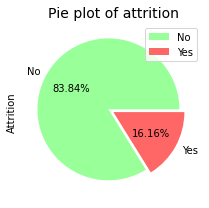

In [17]:
explode=(0.08,0)

pandas_df['Attrition'].value_counts().plot.pie(autopct='%1.2f%%',figsize=(3,3),explode=explode,colors=['#99ff99','#ff6666'])
plt.title("Pie plot of attrition", fontsize=14)
plt.tight_layout()
plt.legend()
plt.show()

### Ration of Attrition based on Gender

In [18]:
df1 = pandas_df.groupby(['Attrition','Gender']).agg({'Gender':'count'})
df1 = df1.rename({'Gender': 'Gender_count'}, axis=1)
df1.reset_index(inplace=True)

print(df1.head())

  Attrition  Gender  Gender_count
0        No  Female          1464
1        No    Male          2141
2       Yes  Female           265
3       Yes    Male           430


Text(0.5, 1.0, 'Gender and Attrition')

<Figure size 720x720 with 0 Axes>

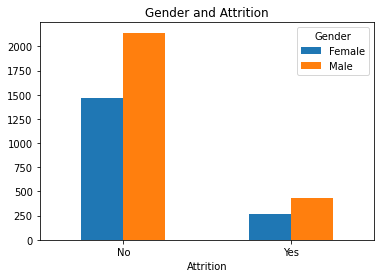

In [19]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['Gender'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Gender and Attrition")

### Ratio of Attrition based on Job Satisfaction

In [20]:
df1 = pandas_df.groupby(['Attrition','JobSatisfaction']).agg({'JobSatisfaction':'count'})
df1 = df1.rename({'JobSatisfaction': 'JobSatisfaction_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

  Attrition  JobSatisfaction  JobSatisfaction_count
0        No                1                    653
1        No                2                    688
2        No                3                   1082
3        No                4                   1182
4       Yes                1                    194
5       Yes                2                    135
6       Yes                3                    214
7       Yes                4                    152


Text(0.5, 1.0, 'Job_Satisfaction vs Attrition')

<Figure size 720x720 with 0 Axes>

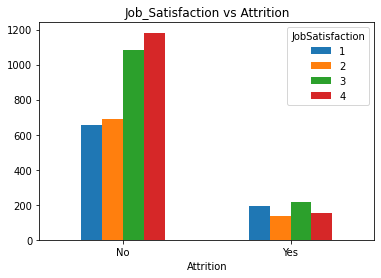

In [21]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['JobSatisfaction'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Job_Satisfaction vs Attrition")

### Ration of Attrition based on Work Life Balance

In [22]:
df1 = pandas_df.groupby(['Attrition','WorkLifeBalance']).agg({'WorkLifeBalance':'count'})
df1 = df1.rename({'WorkLifeBalance': 'WorkLifeBalance_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

  Attrition  WorkLifeBalance  WorkLifeBalance_count
0        No                1                    163
1        No                2                    838
2        No                3                   2234
3        No                4                    370
4       Yes                1                     73
5       Yes                2                    167
6       Yes                3                    375
7       Yes                4                     80


Text(0.5, 1.0, 'Work_life_balance vs Attrition')

<Figure size 720x720 with 0 Axes>

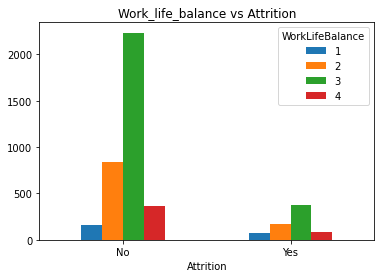

In [23]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['WorkLifeBalance'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Work_life_balance vs Attrition")

### Ration of Attrition based on Age group

In [24]:
df1 = pandas_df.groupby(['Attrition','Age']).agg({'Age':'count'})
df1 = df1.rename({'Age': 'Age_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

   Attrition  Age  Age_count
0         No   18         11
1         No   19          9
2         No   20         15
3         No   21         21
4         No   22         32
..       ...  ...        ...
77       Yes   52          9
78       Yes   53          6
79       Yes   55          9
80       Yes   56          9
81       Yes   58         15

[82 rows x 3 columns]


<AxesSubplot:xlabel='Age', ylabel='count'>

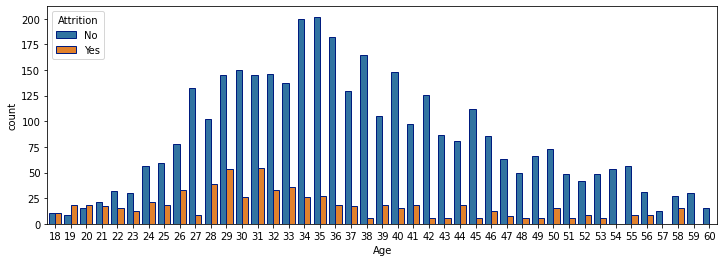

In [25]:
fig_dims=(12,4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='Age', hue='Attrition', ax=ax, data=pandas_df, edgecolor=sns.color_palette("dark", n_colors=1))

In [26]:
df1 = pandas_df.groupby(['Attrition','Age']).agg({'Age':'count'})
df1 = df1.rename({'Age': 'Age_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

   Attrition  Age  Age_count
0         No   18         11
1         No   19          9
2         No   20         15
3         No   21         21
4         No   22         32
..       ...  ...        ...
77       Yes   52          9
78       Yes   53          6
79       Yes   55          9
80       Yes   56          9
81       Yes   58         15

[82 rows x 3 columns]


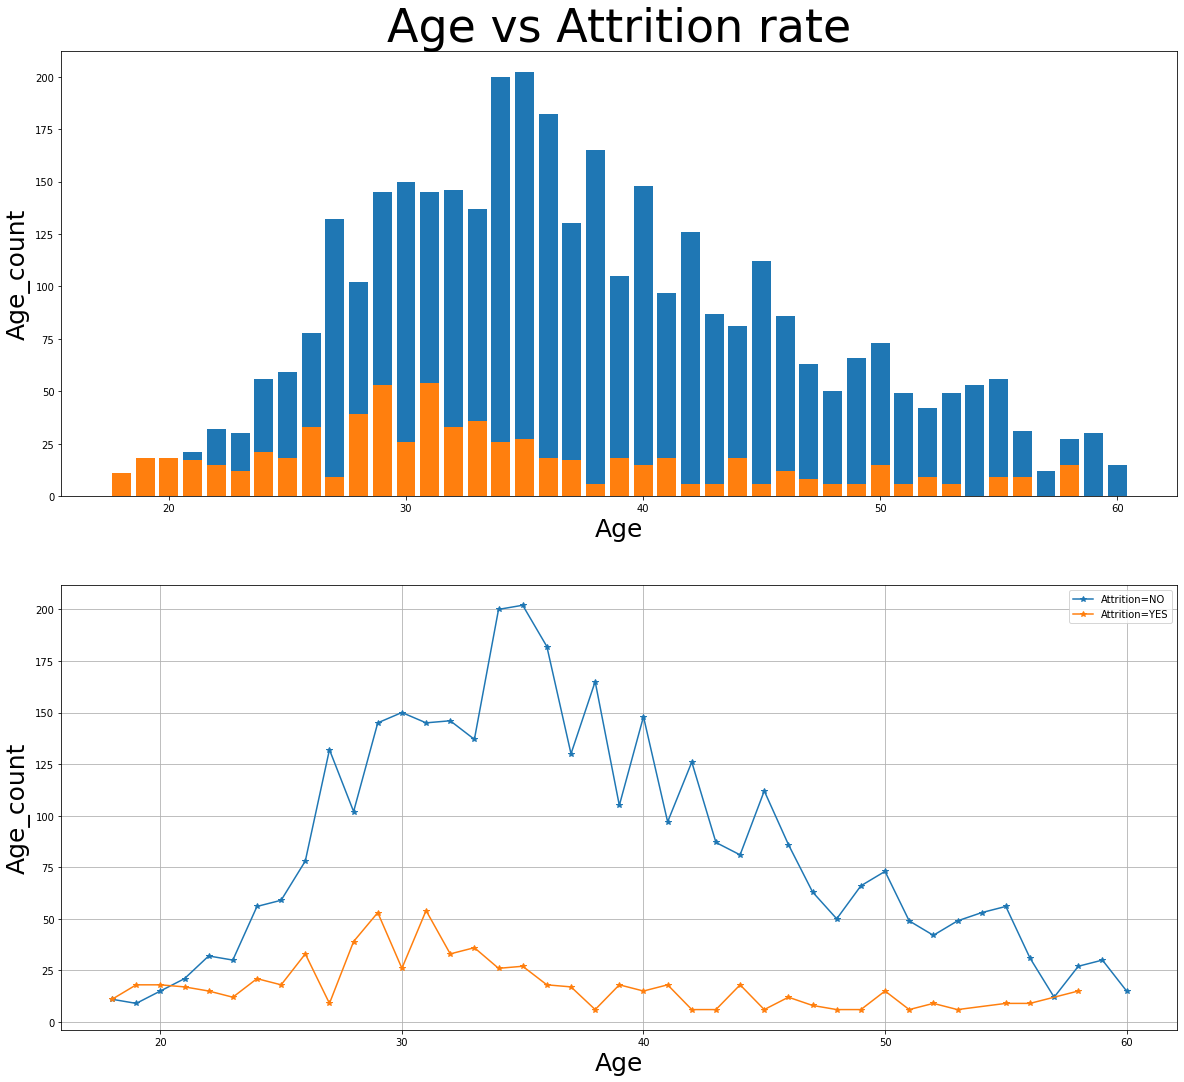

In [27]:
fig, ax =plt.subplots(2,1,figsize=(20,18))

ax[0].bar(df1['Age'].iloc[:43].unique(), df1["Age_count"].iloc[:43])
ax[0].bar(df1['Age'].iloc[43:].unique(), df1["Age_count"].iloc[43:])
ax[0].set_title("Age vs Attrition rate", fontsize=46)
ax[0].set_xlabel('Age', fontsize=25)
ax[0].set_ylabel('Age_count', fontsize=25)
plt.grid(True)

ax[1].plot(df1.Age.iloc[:43], df1.Age_count.iloc[:43], label='Attrition=NO', marker='*')
ax[1].plot(df1.Age.iloc[43:], df1.Age_count.iloc[43:], label='Attrition=YES', marker='*')
ax[1].set_xlabel('Age', fontsize=25)
ax[1].set_ylabel('Age_count', fontsize=25)
plt.legend()

## Lable Endocing

In [28]:
Attrition_indexer = StringIndexer(inputCol="Attrition", outputCol="AttritionIndex")
BusinessTravel_indexer = StringIndexer(inputCol="BusinessTravel", outputCol="BusinessTravelIndex")
Department_indexer = StringIndexer(inputCol="Department", outputCol="DepartmentIndex")
EducationField_indexer = StringIndexer(inputCol="EducationField", outputCol="EducationFieldIndex")
Gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
JobRole_indexer = StringIndexer(inputCol="JobRole", outputCol="JobRoleIndex")
MaritalStatus_indexer = StringIndexer(inputCol="MaritalStatus", outputCol="MaritalStatusIndex")


indexed_1 = Attrition_indexer.fit(null_df).transform(null_df) 
indexed_2 = BusinessTravel_indexer.fit(indexed_1).transform(indexed_1) 
indexed_3 = Department_indexer.fit(indexed_2).transform(indexed_2) 
indexed_4 = EducationField_indexer.fit(indexed_3).transform(indexed_3) 
indexed_5 = Gender_indexer.fit(indexed_4).transform(indexed_4) 
indexed_6 = JobRole_indexer.fit(indexed_5).transform(indexed_5) 
df = MaritalStatus_indexer.fit(indexed_6).transform(indexed_6) 

df.show()

+----------+---+---------+-----------------+--------------------+----------------+---------+--------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+--------------+-------------------+---------------+-------------------+-----------+------------+------------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|Pe

In [29]:
df.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

In [30]:

df = df.withColumn("AttritionIndex",col("AttritionIndex").cast(IntegerType())) \
    .withColumn("BusinessTravelIndex",col("BusinessTravelIndex").cast(IntegerType())) \
    .withColumn("DepartmentIndex",col("DepartmentIndex").cast(IntegerType())) \
    .withColumn("EducationFieldIndex",col("EducationFieldIndex").cast(IntegerType())) \
    .withColumn("GenderIndex",col("GenderIndex").cast(IntegerType())) \
    .withColumn("JobRoleIndex",col("JobRoleIndex").cast(IntegerType())) \
    .withColumn("MaritalStatusIndex",col("MaritalStatusIndex").cast(IntegerType()))

df.printSchema()


root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

In [31]:
cols = ("Attrition","BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus", "Over18")

df_index = df.drop(*cols)
df_index.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsSinceLastPromotion: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- PerformanceRating: integer (null

## Feature Selection

In [32]:
df_index.columns

['EmployeeID',
 'Age',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'JobLevel',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating',
 'AttritionIndex',
 'BusinessTravelIndex',
 'DepartmentIndex',
 'EducationFieldIndex',
 'GenderIndex',
 'JobRoleIndex',
 'MaritalStatusIndex']

In [33]:
formula = RFormula(
    formula="AttritionIndex ~ EmployeeID + Age + DistanceFromHome + Education + EmployeeCount + JobLevel + MonthlyIncome + NumCompaniesWorked + PercentSalaryHike + StandardHours + StockOptionLevel + TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + YearsSinceLastPromotion + YearsWithCurrManager + EnvironmentSatisfaction + JobSatisfaction + PerformanceRating + BusinessTravelIndex + DepartmentIndex + EducationFieldIndex + GenderIndex + JobRoleIndex + MaritalStatusIndex",
    featuresCol="features",
    labelCol="label")

output = formula.fit(df_index).transform(df_index)
output.select("features", "label").show()
final_data = output.select("features", "label")

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,51.0,6.0,2.0...|  0.0|
|[2.0,31.0,10.0,1....|  1.0|
|[3.0,32.0,17.0,4....|  0.0|
|[4.0,38.0,2.0,5.0...|  0.0|
|[5.0,32.0,10.0,1....|  0.0|
|[6.0,46.0,8.0,3.0...|  0.0|
|[7.0,28.0,11.0,2....|  1.0|
|[8.0,29.0,18.0,3....|  0.0|
|[9.0,31.0,1.0,3.0...|  0.0|
|[10.0,25.0,7.0,4....|  0.0|
|[11.0,45.0,17.0,2...|  0.0|
|[13.0,55.0,14.0,4...|  0.0|
|[14.0,47.0,1.0,1....|  1.0|
|[15.0,28.0,1.0,3....|  0.0|
|[16.0,37.0,1.0,3....|  0.0|
|[17.0,21.0,3.0,2....|  0.0|
|[18.0,37.0,1.0,3....|  0.0|
|[19.0,35.0,7.0,4....|  0.0|
|[20.0,38.0,8.0,3....|  0.0|
|[21.0,26.0,1.0,4....|  0.0|
+--------------------+-----+
only showing top 20 rows



### Data Projection

In [46]:
df = df_index.toPandas()
cat = ['AttritionIndex','BusinessTravelIndex','DepartmentIndex',
       'Education','EducationFieldIndex','GenderIndex', 'NumCompaniesWorked',
       'JobLevel','JobRoleIndex','MaritalStatusIndex','NumCompaniesWorked',
       'StockOptionLevel','TrainingTimesLastYear','EnvironmentSatisfaction',
       'JobSatisfaction','WorkLifeBalance','JobInvolvement','PerformanceRating']

col=['Age','AttritionIndex','BusinessTravelIndex','DepartmentIndex',
     'Education','EducationFieldIndex','GenderIndex', 'StandardHours', 
     'NumCompaniesWorked', 'JobLevel','JobRoleIndex','MaritalStatusIndex',
     'NumCompaniesWorked','Over18','StockOptionLevel','TrainingTimesLastYear',
     'EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','JobInvolvement',
     'PerformanceRating']

Feature Selection

In [47]:
## Cheking constant feature
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(df)

var_thres.get_support()

print(df.columns[var_thres.get_support()])


constant_columns = [column for column in df.columns
                    if column not in df.columns[var_thres.get_support()]]
print(constant_columns)
print(len(constant_columns))
print("Shape: ", df.shape)

Index(['EmployeeID', 'Age', 'DistanceFromHome', 'Education', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'AttritionIndex',
       'BusinessTravelIndex', 'DepartmentIndex', 'EducationFieldIndex',
       'GenderIndex', 'JobRoleIndex', 'MaritalStatusIndex'],
      dtype='object')
['EmployeeCount', 'StandardHours']
2
Shape:  (4300, 28)


<AxesSubplot:title={'center':'Analyzing Attrition rate of a Company'}>

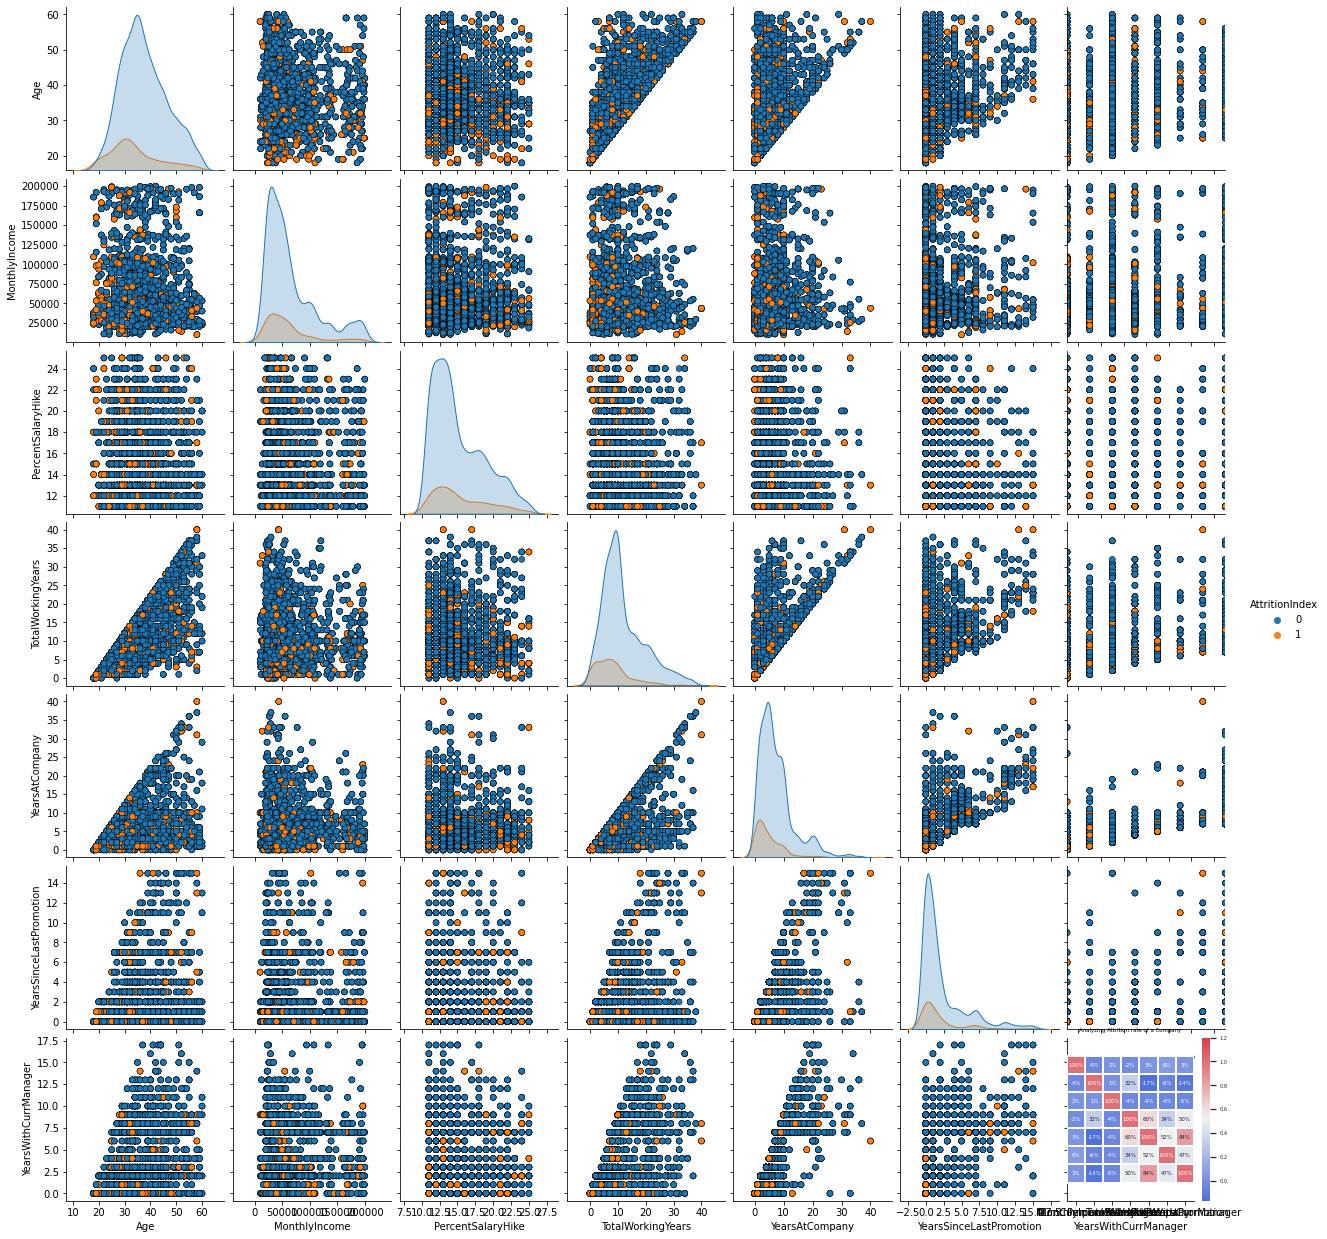

In [48]:
## Correlation among numerical features
pp = sns.pairplot(df[["Age", "MonthlyIncome", "PercentSalaryHike", 
                      "TotalWorkingYears", "YearsAtCompany", 
                      "YearsSinceLastPromotion", "YearsWithCurrManager", 
                      "AttritionIndex"]], hue = "AttritionIndex", 
                  plot_kws=dict(edgecolor="k", linewidth=0.5), diag_kind="kde", diag_kws=dict(shade=True))
t = fig.suptitle('Analyzing Attrition rate of a Company', fontsize=30)

sns.set(font_scale=0.45)
plt.title('Analyzing Attrition rate of a Company')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(df[["MonthlyIncome", "NumCompaniesWorked", 
                "PercentSalaryHike", "TotalWorkingYears", 
                "YearsAtCompany", "YearsSinceLastPromotion", 
                "YearsWithCurrManager"]].corr("spearman"), 
            vmax=1.2, annot=True, square='square', cmap=cmap, fmt = '.0%', linewidths=2)

In [49]:
# With the following function we can select highly correlated features
# It will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr("spearman")
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.85)
corr_features

set()

In [50]:
## Relation among categorical features
f_p_values = chi2(df[cat],df["AttritionIndex"])

p_values = pd.Series(f_p_values[1])
p_values.index = cat
p_values.sort_values(ascending=False)

BusinessTravelIndex        0.895372
EducationFieldIndex        0.818220
PerformanceRating          0.726368
MaritalStatusIndex         0.709260
JobInvolvement             0.678256
StockOptionLevel           0.616951
Education                  0.548626
JobLevel                   0.461612
GenderIndex                0.344990
JobRoleIndex               0.201359
WorkLifeBalance            0.094802
DepartmentIndex            0.021695
TrainingTimesLastYear      0.019334
NumCompaniesWorked         0.000012
NumCompaniesWorked         0.000012
EnvironmentSatisfaction    0.000007
JobSatisfaction            0.000006
AttritionIndex             0.000000
dtype: float64

In [51]:
# Null Hypothesis: The null hypothesis states that there is no relationship between the two variables
cnt = 0
for i in p_values:
    if i > 0.05:
        print("There is no relationship", p_values.index[cnt], i)
    else:
        print("There is relationship", p_values.index[cnt], i)
    
    cnt += 1

There is relationship AttritionIndex 0.0
There is no relationship BusinessTravelIndex 0.8953715471884904
There is relationship DepartmentIndex 0.021694675251644813
There is no relationship Education 0.5486255321804868
There is no relationship EducationFieldIndex 0.8182197538702516
There is no relationship GenderIndex 0.34499020919865886
There is relationship NumCompaniesWorked 1.1805875636706567e-05
There is no relationship JobLevel 0.4616123736618736
There is no relationship JobRoleIndex 0.20135891878027345
There is no relationship MaritalStatusIndex 0.709259707408415
There is relationship NumCompaniesWorked 1.1805875636706567e-05
There is no relationship StockOptionLevel 0.6169511136859199
There is relationship TrainingTimesLastYear 0.019334068615409924
There is relationship EnvironmentSatisfaction 6.89940647429226e-06
There is relationship JobSatisfaction 6.415076648324704e-06
There is no relationship WorkLifeBalance 0.09480202951284945
There is no relationship JobInvolvement 0.6782

<AxesSubplot:title={'center':'Analyzing Attrition rate of a Company'}>

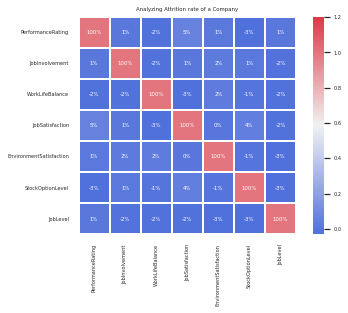

In [52]:
## One more way to check relation among categorical features i.e. Spearman Correlation

sns.set(font_scale=0.45)
plt.title('Analyzing Attrition rate of a Company')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(df[["PerformanceRating", "JobInvolvement", "WorkLifeBalance", 
                "JobSatisfaction", "EnvironmentSatisfaction", "StockOptionLevel", 
                "JobLevel"]].corr("spearman"), 
            vmax=1.2, annot=True, square='square', cmap=cmap, fmt = '.0%', linewidths=2)

P_Value of EmployeeID and Attrition 0.9108926338446552
There is no relation between EmployeeID and Attrition 

P_Value of Age and Attrition 1.0459177113363792e-24
There is relation between Age and Attrition 

P_Value of MonthlyIncome and Attrition 0.03239134262287118
There is relation between MonthlyIncome and Attrition 

P_Value of PercentSalaryHike and Attrition 0.023980569178766176
There is relation between PercentSalaryHike and Attrition 

P_Value of TotalWorkingYears and Attrition 8.487205930170032e-29
There is relation between TotalWorkingYears and Attrition 

P_Value of YearsAtCompany and Attrition 1.3868661645694397e-18
There is relation between YearsAtCompany and Attrition 

P_Value of YearsSinceLastPromotion and Attrition 0.04969282656437934
There is relation between YearsSinceLastPromotion and Attrition 

P_Value of YearsWithCurrManager and Attrition 1.171598131119486e-24
There is relation between YearsWithCurrManager and Attrition 

Index(['Age', 'DistanceFromHome', 'Educat

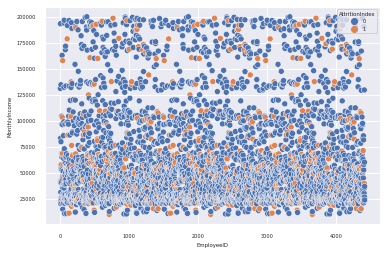

In [53]:
## Relation among numerical and classification column
df_anova = df[["EmployeeID", "Age", "MonthlyIncome", "PercentSalaryHike", 
               "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager", "AttritionIndex"]]
grps = pd.unique(df_anova.AttritionIndex.values)
grps

for i in range(len(df_anova.columns)-1):
    
    d_data = {grp:df_anova[df_anova.columns[i]][df_anova.AttritionIndex == grp] for grp in grps}

    F, p = stats.f_oneway(d_data[0], d_data[1])
    print("P_Value of {} and Attrition".format(df_anova.columns[i]), p)

    if p < 0.05:
        print("There is relation between {} and Attrition \n".format(df_anova.columns[i]))
    else:
        print("There is no relation between {} and Attrition \n".format(df_anova.columns[i]))

sns.scatterplot(x="EmployeeID", y="MonthlyIncome", hue="AttritionIndex", data=df)

df.drop(['EmployeeCount', 'EmployeeID', 'StandardHours', "BusinessTravelIndex", 
         "DepartmentIndex", "GenderIndex", "JobLevel", "StockOptionLevel", "JobInvolvement", "PerformanceRating", "MonthlyIncome"], 
        axis=1, inplace=True)
print(df.columns)
print(len(df.columns))

Target Feature Separation

In [54]:
x = df.drop("AttritionIndex", axis=1)
y = df.AttritionIndex

In [55]:
print(len(y[y==0]), len(y[y==1]))

3605 695


Handling Imbalanced data

In [56]:
os =  RandomOverSampler(sampling_strategy=1)

x_res, y_res = os.fit_resample(x, y) 

In [57]:
print(len(y_res[y_res==0]), len(y_res[y_res==1]))
print(len(x_res))

3605 3605
7210


Scaling the data

In [58]:
scaler = StandardScaler()
features = scaler.fit_transform(x_res)
features

array([[ 1.61388943, -0.398391  , -0.87777193, ..., -0.84580275,
         0.61592285, -1.0438079 ],
       [-0.4888506 ,  0.10500877, -1.85082476, ..., -0.84580275,
        -0.65070686,  0.3039455 ],
       [-0.3837136 ,  0.98595837,  1.06833373, ...,  2.19041226,
        -1.07291676, -1.0438079 ],
       ...,
       [ 1.08820442, -0.65009088,  1.06833373, ..., -0.086749  ,
         1.46034266, -1.0438079 ],
       [ 2.03443743,  0.86010843,  0.0952809 , ...,  1.43135851,
         0.19371295,  0.3039455 ],
       [-1.75049462, -0.14669111, -0.87777193, ..., -0.84580275,
        -1.07291676,  0.3039455 ]])

## Training Data & Test Data

In [59]:
x_train, x_test, y_train, y_test = train_test_split(features, y_res, test_size=0.3, random_state=1)

In [34]:
# Split the training and testing set.
train_data,test_data = final_data.randomSplit([0.7,0.3])

## Modeling

### Gradient boosted tree classifier

In [35]:
gbt = GBTClassifier(labelCol='label',featuresCol='features')

In [36]:
gbt_model = gbt.fit(train_data)

In [37]:
gbt_predictions = gbt_model.transform(test_data)

In [38]:
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'label')

In [39]:
my_binary_gbt_eval = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')
print("GBT")
print(my_binary_gbt_eval.evaluate(gbt_predictions))

GBT
0.6869339184667403


22/10/12 07:13:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/12 07:13:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


### Single Decision Tree

In [40]:
dtc = DecisionTreeClassifier(labelCol='label',featuresCol='features')

In [41]:
dtc_model = dtc.fit(train_data)

In [42]:
dtc_predictions = dtc_model.transform(test_data)

In [43]:
print("DTC")
print(my_binary_eval.evaluate(dtc_predictions))

DTC
0.4223318617403339


### XGBoost Modeling

In [60]:
# GridSearchCV - Hyperparameter tuning
def xgb_grid_search(X, y):
    # Create a dictionary of all values we want to test
    param_grid = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    xgb = XGBClassifier()
    
    #use gridsearch to test all values
    xgb_gscv =  RandomizedSearchCV(estimator = xgb,
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = -1)
    #fit model to data
    xgb_gscv.fit(X, y)
    
    return xgb_gscv.best_params_

In [61]:
xgb_grid_search(x_train, y_train)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


{'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [62]:
xgb = XGBClassifier(min_child_weight=3, max_depth=10, learning_rate=0.15, gamma=0.4, 
                    colsample_bytree=0.5)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [63]:
y_pred_xgb = xgb.predict(x_test)

In [64]:
print(classification_report(y_test, y_pred_xgb))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall:",metrics.recall_score(y_test, y_pred_xgb))

print(xgb.score(x_train,y_train))
print(xgb.score(x_test,y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1074
           1       0.99      1.00      1.00      1089

    accuracy                           1.00      2163
   macro avg       1.00      1.00      1.00      2163
weighted avg       1.00      1.00      1.00      2163

Accuracy: 0.9967637540453075
Precision: 0.9936131386861314
Recall: 1.0
0.9998018624925699
0.9967637540453075


In [65]:
xgb_tacc = xgb.score(x_test,y_test)

<AxesSubplot:>

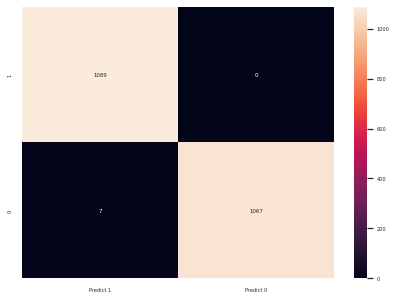

In [66]:
# Confusion Matrix of XGBoost

cm = metrics.confusion_matrix(y_test, y_pred_xgb, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

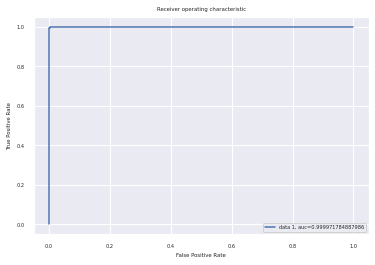

In [67]:
# AUC of XGBoost
y_pred_proba = xgb.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
fpr 
tpr

auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

WorkLifeBalance            8.925402e-01
JobSatisfaction            5.109564e-01
EnvironmentSatisfaction    5.041237e-01
PercentSalaryHike          4.764233e-01
JobRoleIndex               6.059637e-04
NumCompaniesWorked         1.920937e-04
YearsWithCurrManager       2.398908e-07
YearsSinceLastPromotion    6.305499e-16
YearsAtCompany             2.423616e-25
dtype: float64

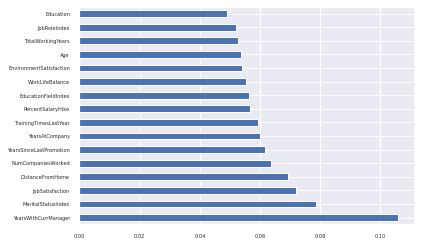

In [70]:
# Features importance in making predictions by XGBoost Model
pd.Series(xgb.feature_importances_, index=x.columns).nlargest(20)

feat_importances = pd.Series(xgb.feature_importances_, index=x.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')

x.columns

cat2 = ["JobRoleIndex", "NumCompaniesWorked", "PercentSalaryHike", "YearsAtCompany", 
        "YearsSinceLastPromotion", "YearsWithCurrManager", "EnvironmentSatisfaction", 
        "JobSatisfaction", "WorkLifeBalance"]

f_p_values = chi2(df[cat2],df["MaritalStatusIndex"])

p_values = pd.Series(f_p_values[1])
p_values.index = cat2
p_values.sort_values(ascending=False)

In [71]:
# Null Hypothesis: The null hypothesis states that there is no relationship between the two variables
cnt = 0
for i in p_values:
    if i > 0.05:
        print("There is no relationship", p_values.index[cnt], i)
    else:
        print("There is relationship", p_values.index[cnt], i)
    
    cnt += 1

There is relationship JobRoleIndex 0.0006059636641347932
There is relationship NumCompaniesWorked 0.00019209372616110402
There is no relationship PercentSalaryHike 0.4764233133407769
There is relationship YearsAtCompany 2.423615940950927e-25
There is relationship YearsSinceLastPromotion 6.305498956328629e-16
There is relationship YearsWithCurrManager 2.398908282006925e-07
There is no relationship EnvironmentSatisfaction 0.5041237266195266
There is no relationship JobSatisfaction 0.5109564150310546
There is no relationship WorkLifeBalance 0.8925401765820914


### SVM

In [72]:
# GridSearchCV - Hyperparameter tuning
def svm_grid_search(X, y):
    #create a dictionary of all values we want to test
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 0.4, 0.2, 0.8],
                  'kernel': ['rbf', 'poly', 'sigmoid']}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    svm = SVC()
    
    #use gridsearch to test all values
    svm_gscv = GridSearchCV(estimator = svm,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = -1)
    #fit model to data
    svm_gscv.fit(X, y)
    
    return svm_gscv.best_params_

In [ ]:
svm_grid_search(x_train, y_train)

In [ ]:
svm = SVC(gamma=1, C=1, kernel='rbf', probability=True)

In [ ]:
svm.fit(x_train, y_train)

In [ ]:
y_pred_svm = svm.predict(x_test)

In [ ]:
print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))

In [ ]:
# Confusion Matrix of SVM
print(metrics.classification_report(y_test, y_pred_svm))

svm_tacc = svm.score(x_test, y_test)

cm = metrics.confusion_matrix(y_test, y_pred_svm, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# AUC od SVM
y_pred_proba = svm.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
fpr 
tpr

auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### Random Forest

In [ ]:
# GridSearchCV - Hyperparameter

def rf_grid_search(X, y):
    #create a dictionary of all values we want to test
    param_grid = { 
    'n_estimators': [5,10,20,40,50,60,70,80,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Random Forest model
    rf = RandomForestClassifier()
    
    #use gridsearch to test all values
    rf_gscv = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
    #fit model to data
    rf_gscv.fit(X, y)
    
    return rf_gscv.best_params_

In [ ]:
rf_grid_search(x_train, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=8, max_features='sqrt')
rf.fit(x_train,y_train)
y_pred2 = rf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred2))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print("Precision:",metrics.precision_score(y_test, y_pred2))
print("Recall:",metrics.recall_score(y_test, y_pred2))

print(rf.score(x_train,y_train))
print(rf.score(x_test,y_test))

rf_tacc = rf.score(x_test,y_test)

In [ ]:
# Confusion Matrix of Random Forest
cm = metrics.confusion_matrix(y_test, y_pred2, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# AUC of Random Forest
y_pred_proba = rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
fpr 
tpr

auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")